# Customer Segment & Chips Purchasing Behavior Analysis

## Introduction

This project is part of the Quantium Virtual Internship, with the objective of exploring customer purchasing behavior and identifying actionable insights to guide category strategy.

In this analysis, two datasets were used — transaction data and customer demographic data — to understand how different customer segments purchase snack products, particularly chips. The goal is to uncover patterns in who buys what, when, and in which pack sizes, enabling Julia, the Category Manager, to make data-driven decisions for the upcoming category review and optimize chip assortment for the holiday season.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Load data

In [2]:
transactionData = pd.read_excel("QVI_transaction_data.xlsx")

In [3]:
customerData = pd.read_csv("QVI_purchase_behaviour.csv")

## Exploratory Data Analysis

### Examining transaction data

We first ensure that numeric columns are stored as numbers and date columns are in the correct format.

In [4]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


The `DATE` column is currently stored as an integer. Let's convert it to proper date format.

In [5]:
from datetime import datetime

# Convert DATE column to a date format
transactionData["DATE"] = pd.to_datetime(transactionData["DATE"], origin="1899-12-30", unit="D")

Next, let's confirm we are examining the correct products by reviewing the `PROD_NAME` column.

In [6]:
transactionData["PROD_NAME"].value_counts().reset_index().head(3)

,PROD_NAME,count
0,Kettle Mozzarella Basil & Pesto 175g,3304
1,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3296
2,Cobs Popd Swt/Chlli &Sr/Cream Chips 110g,3269


In [7]:
transactionData["PROD_NAME"].nunique()

114

There are 114 unique products, but not all of them are chips. We will systematically check by summarizing the most common words in product names.

In [8]:
words = []
for name in transactionData["PROD_NAME"].unique():
    words.extend(name.split(" "))

productWords = pd.DataFrame(words, columns=["words"])
productWords["words"] = productWords["words"].str.lower()
productWords = productWords[~productWords["words"].str.contains(r"\d")]
productWords = productWords[productWords["words"].str.contains(r"^[a-z]+$")]

productWords["words"].value_counts().reset_index().head(10)

,words,count
0,chips,21
1,smiths,16
2,cut,14
3,crinkle,14
4,kettle,13
5,salt,12
6,cheese,12
7,original,10
8,salsa,9
9,doritos,9


While some products like salsa are present, we are only interested in chips. We'll remove non-chip items.

In [9]:
transactionData = transactionData[~transactionData["PROD_NAME"].str.lower().str.contains("salsa")]

#### Descriptive Statistics & Outliers
We examine descriptive statistics to identify any anomalies or missing values.

In [10]:
transactionData.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


No missing values exist, but there is a potential outlier: **200 packets of chips purchased in a single transaction**. Let's investigate:

In [11]:
# Filter the dataset to find the outlier
outlier = transactionData[transactionData["PROD_QTY"] == 200]
outlier

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


Both transactions involve the same loyalty card and appear commercial, not typical retail behavior. We'll remove this customer:

In [12]:
transactionData = transactionData[transactionData["LYLTY_CARD_NBR"] != outlier["LYLTY_CARD_NBR"].iloc[0]]

In [13]:
# Re‐examine transaction data
transactionData.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897


#### Transactions Over Time

To check for missing or inconsistent records, we examine the number of transactions per day. We first generate a sequence of dates from **1 July 2018 to 30 June 2019** and compare daily transaction counts.

In [14]:
transactionData["DATE"].value_counts().reset_index().head()

,DATE,count
0,2018-12-24,865
1,2018-12-23,853
2,2018-12-22,840
3,2018-12-19,839
4,2018-12-20,808


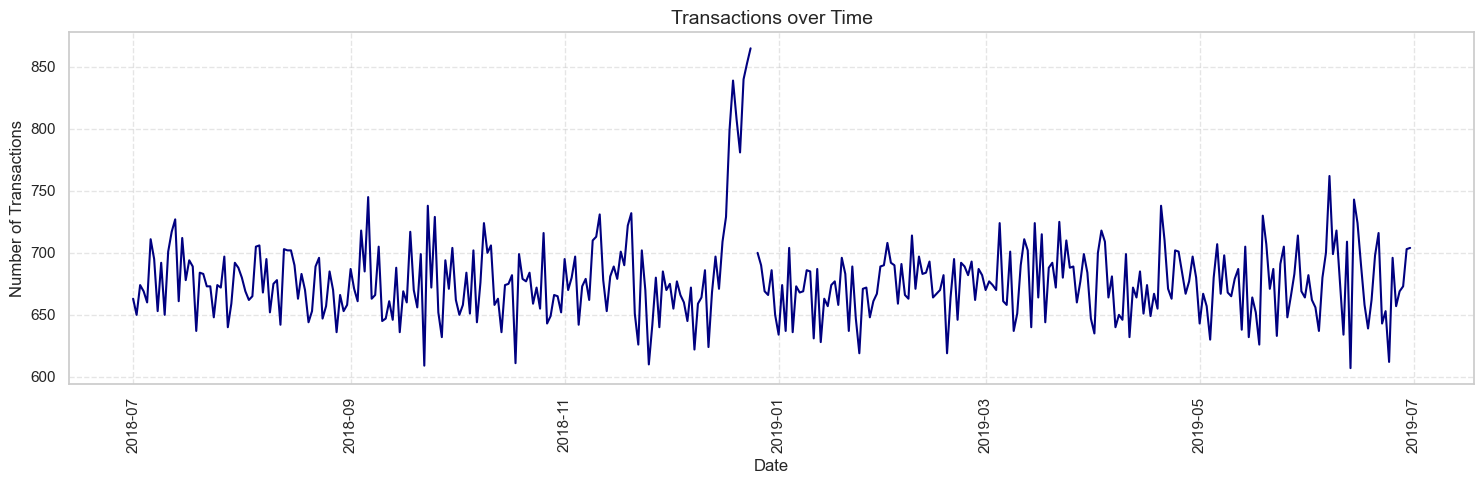

In [15]:
# Create a sequence of dates and join this the count of transactions by date
all_dates = pd.DataFrame({'DATE': pd.date_range(start="2018-07-01", end="2019-06-30")})
transactions_by_day = transactionData.groupby('DATE').size().reset_index(name='N')
transactions_by_day = all_dates.merge(transactions_by_day, on='DATE', how='left')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,5))
plt.plot(transactions_by_day['DATE'], transactions_by_day['N'], color='navy')
plt.title("Transactions over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The overall trend shows relatively stable sales throughout the year, with a **clear peak in December**, reflecting holiday season demand.
Let’s zoom in to examine this period more closely.

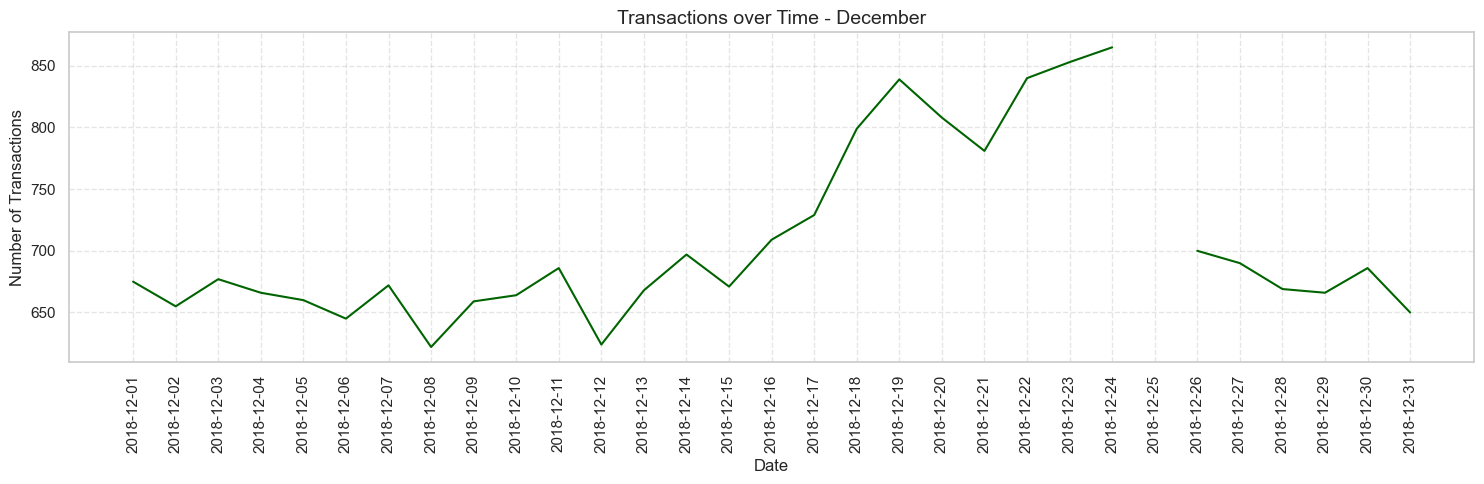

In [16]:
# Filter to December and look at individual days
transactions_dec = transactions_by_day[transactions_by_day['DATE'].dt.month == 12]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,5))
plt.plot(transactions_dec['DATE'], transactions_dec['N'], color='darkgreen')
plt.title("Transactions over Time - December", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(transactions_dec['DATE'], rotation=90)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Zooming in on December, we can observe a more detailed view of purchases: sales increase steadily leading up to Christmas (24–25 December), followed by a temporary drop as stores were closed.

#### Feature Engineering: Pack Size & Brand

We extract pack size from the product name:

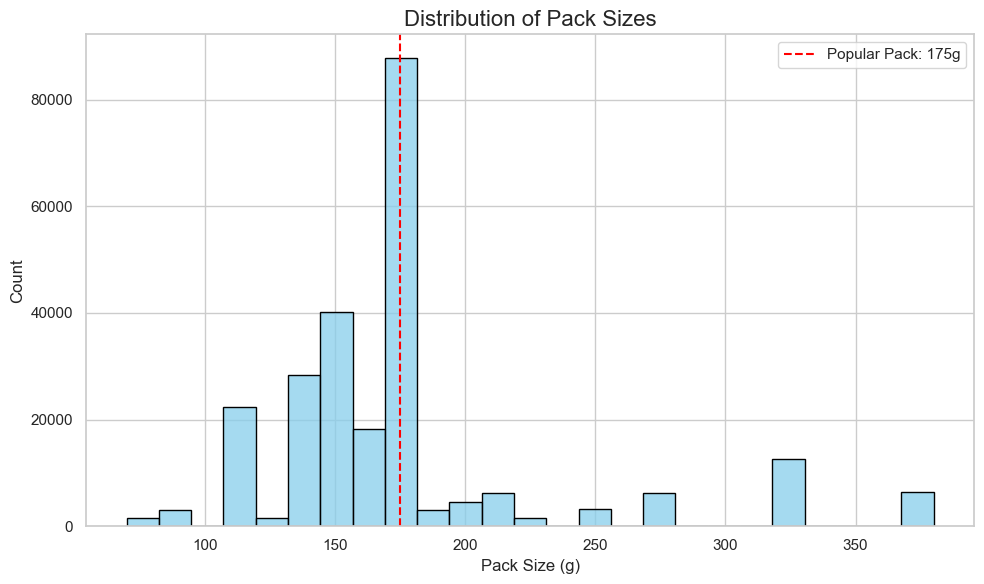

In [17]:
# Extract pack size from product name
transactionData["PACK_SIZE"] = pd.to_numeric(transactionData["PROD_NAME"].str.extract(r"(\d+)")[0])

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(transactionData["PACK_SIZE"], bins=25, color="skyblue", edgecolor="black")

plt.axvline(175, color="red", linestyle="--", label="Popular Pack: 175g")
plt.title("Distribution of Pack Sizes", fontsize=16)
plt.xlabel("Pack Size (g)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

Most chips are sold in **125–175g packs**, with **175g being the most popular**. Smaller packs, such as 75g or 134g, are less common, while jumbo packs (e.g., 220g) are rare. 

Next, we extract brand names from the product names:

In [18]:
# Create Brands
transactionData["BRAND"] = transactionData["PROD_NAME"].str.split(" ").str[0].str.upper()
# Clean brand names
transactionData["BRAND"] = transactionData["BRAND"].replace({"RED": "RRD", "SNBTS": "SUNBITES", "INFZNS": "INFUZIONS", "WW": "WOOLWORTHS",
                                                             "SMITH": "SMITHS", "NCC": "NATURAL", "DORITO": "DORITOS", "GRAIN": "GRNWVES"})
transactionData["BRAND"].value_counts().reset_index().head()

,BRAND,count
0,KETTLE,41288
1,SMITHS,30353
2,DORITOS,25224
3,PRINGLES,25102
4,RRD,16321


Top brands are KETTLE, SMITHS, DORITOS, PRINGLES, and RRD.

### Examining customer data

With the transaction dataset cleaned and outliers addressed, we now turn to the customer dataset to explore its structure and key features.

In [19]:
customerData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Descriptive statistics confirm there are no missing values and `LYLTY_CARD_NBR` is unique for each customer.

In [20]:
customerData.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


Let’s inspect the first few entries in the `LIFESTAGE` and `PREMIUM_CUSTOMER` columns:

In [21]:
customerData[["LIFESTAGE", "PREMIUM_CUSTOMER"]].reset_index().head(3)

,index,LIFESTAGE,PREMIUM_CUSTOMER
0,0,YOUNG SINGLES/COUPLES,Premium
1,1,YOUNG SINGLES/COUPLES,Mainstream
2,2,YOUNG FAMILIES,Budget


Since no apparent issues are observed, we can join the transaction and customer datasets for analysis:

In [22]:
data = transactionData.merge(customerData, on="LYLTY_CARD_NBR", how="left")

In [23]:
data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

No nulls exist — every transaction is linked to a customer.

### Data Analysis on Customer Segments

With the data cleaned and merged, we can now explore customer purchasing behavior using key metrics of interest:

* **Total Spend:** Identify which customers spend the most on chips.  
* **Customer Counts:** Understand how many customers belong to each segment.  
* **Units Purchased:** Examine the number of chips purchased per customer by segment.  
* **Average Price per Unit:** Analyze the average price paid per chip by different customer segments.  

Additional context, such as total customer spend over the period or per transaction and the proportion of customers in each segment, can further enrich the analysis.

#### Total Sales by Segment
We begin by calculating total sales based on `LIFESTAGE` and `PREMIUM_CUSTOMER` to visualize purchasing patterns of each segment over the year.

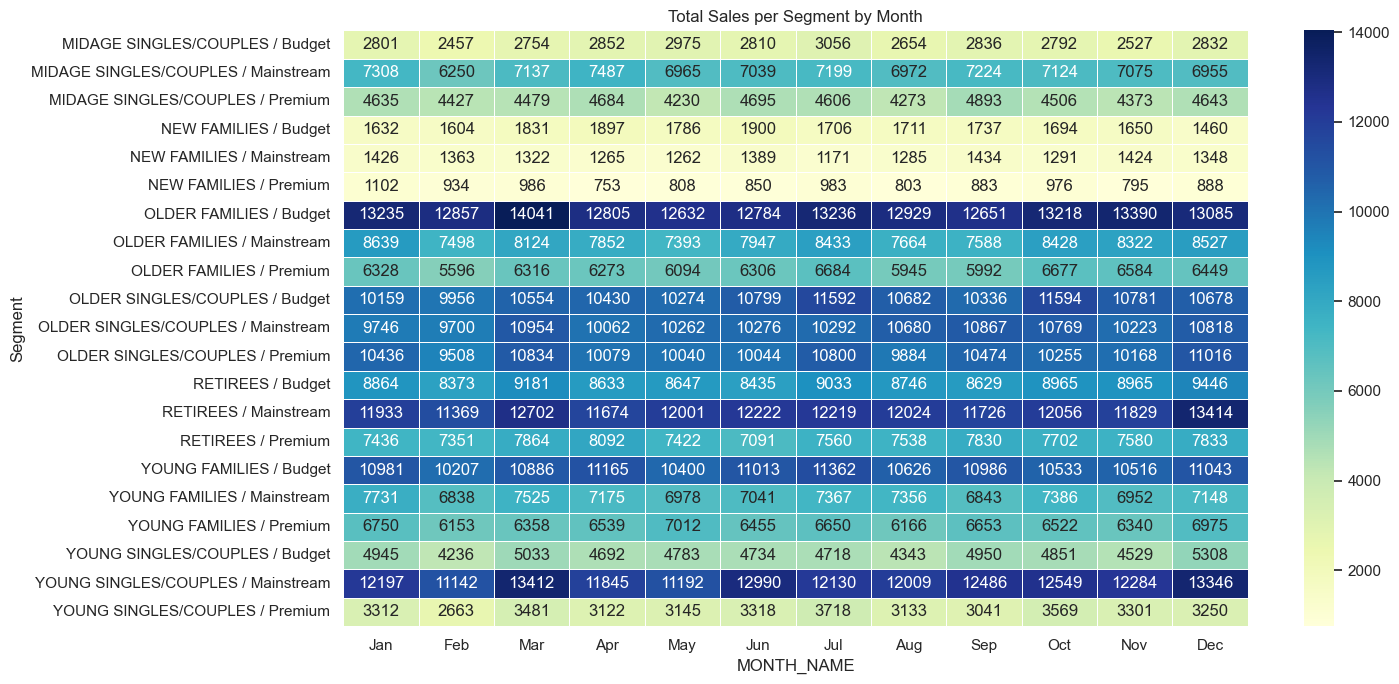

In [24]:
data['Segment'] = data['LIFESTAGE'] + " / " + data['PREMIUM_CUSTOMER']
data["MONTH_NAME"] = pd.Categorical(data["DATE"].dt.strftime("%b"), categories=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], 
                                    ordered=True)
pivot_sales = data.groupby(['MONTH_NAME','Segment'], as_index=False, observed=False)['TOT_SALES'].sum() \
                  .pivot(index='Segment', columns='MONTH_NAME', values='TOT_SALES')

plt.figure(figsize=(15,7))
sns.heatmap(pivot_sales, cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".0f")
plt.title("Total Sales per Segment by Month")
plt.tight_layout()
plt.show()

Older Families and Retirees exhibit stable spending throughout the year, while young Singles/Couples show fluctuating spending, likely influenced by promotions or seasonal needs.

#### Customer Distribution
Next, we explore the distribution across all segments to highlight which customer groups contribute the most to chip sales.

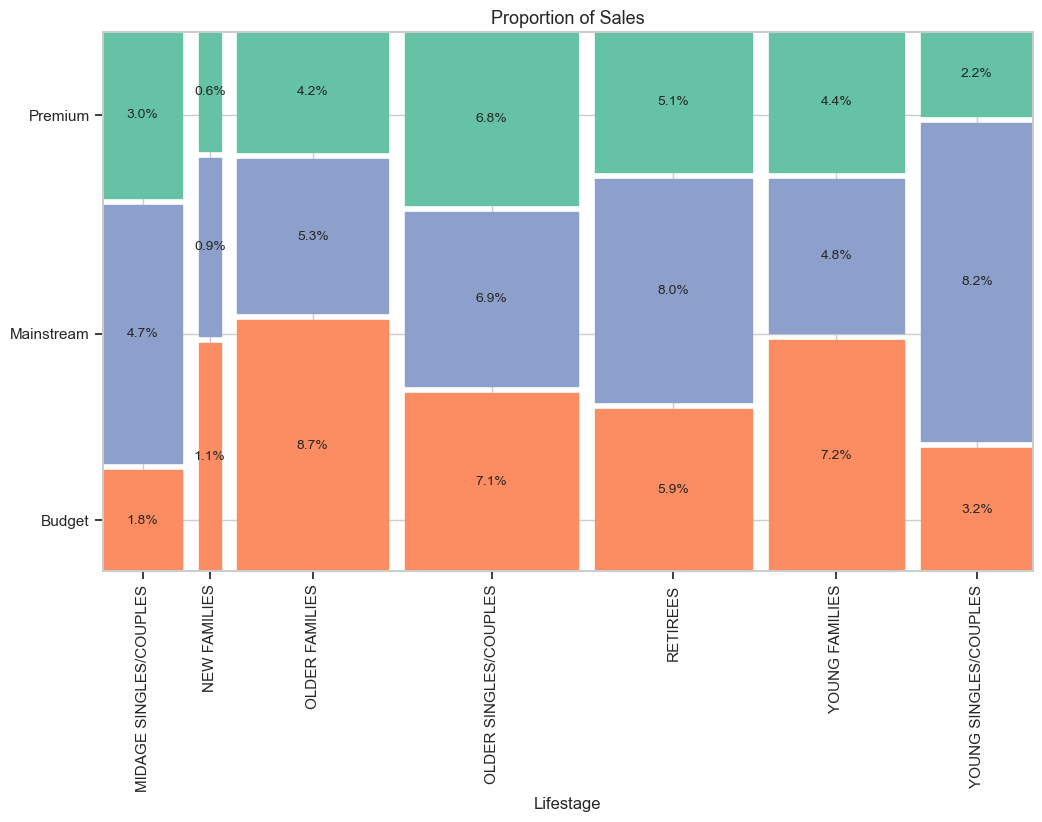

In [25]:
from statsmodels.graphics.mosaicplot import mosaic

# Total sales by segment
sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum()
total = sales.sum()

# Colors for customer type
colors = dict(zip(data['PREMIUM_CUSTOMER'].unique(), sns.color_palette("Set2")))

# Mosaic plot
fig, ax = plt.subplots(figsize=(12, 7))
props = lambda k: {'color': colors[k[1]]}
mosaic(sales, properties=props, labelizer=lambda k: "", ax=ax, gap=0.02)

ax.set_title("Proportion of Sales", fontsize=13)
ax.set_xlabel("Lifestage")

# Add percentage labels
for patch, value in zip(ax.patches, sales):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f"{value/total*100:.1f}%", ha='center', va='center', fontsize=10)

# Rotate X labels
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Sales are primarily coming from Budget - Older Families, Mainstream - Young Singles/Couples, and Mainstream - Retirees.

#### Number of Customers by Segment
Let’s explore whether these higher sales are driven by a larger number of customers in these segments or by higher spending per customer.

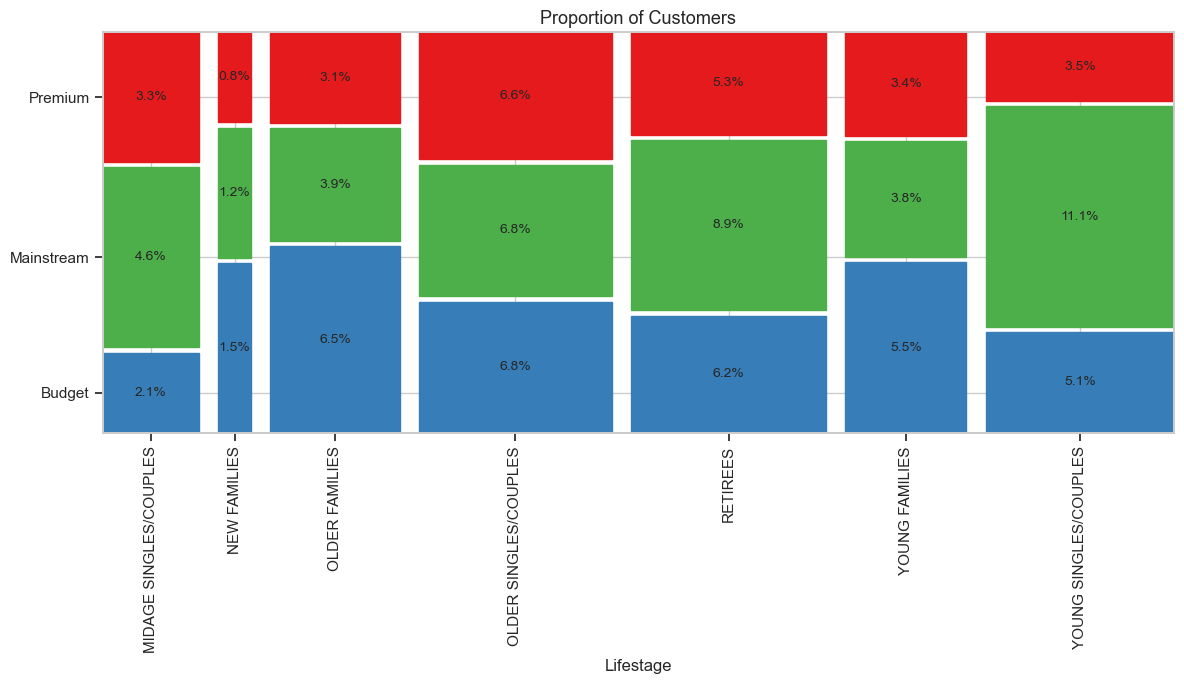

In [26]:
from statsmodels.graphics.mosaicplot import mosaic

# Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
customers = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()
total = customers.sum()

# Colors for customer type
colors = dict(zip(data['PREMIUM_CUSTOMER'].unique(), sns.color_palette("Set1")))
props = lambda k: {'color': colors[k[1]]}

# Mosaic plot
fig, ax = plt.subplots(figsize=(12, 7))
mosaic(customers, properties=props, labelizer=lambda k: "", ax=ax, gap=0.02)

ax.set_title("Proportion of Customers", fontsize=13)
ax.set_xlabel("Lifestage")

# Percentage label
for patch, value in zip(ax.patches, customers):
    x = patch.get_x() + patch.get_width()/2
    y = patch.get_y() + patch.get_height()/2
    ax.text(x, y, f"{value/total*100:.1f}%", ha='center', va='center', fontsize=10)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

There are more Mainstream - Young Singles/Couples and Mainstream - Retirees buying chips, which explains the higher sales in these segments. However, this is less of a factor for the Premium - New Families segment.

#### Average Units per Customer
Higher sales could also result from customers buying more units of chips per transaction. Let’s investigate this next.

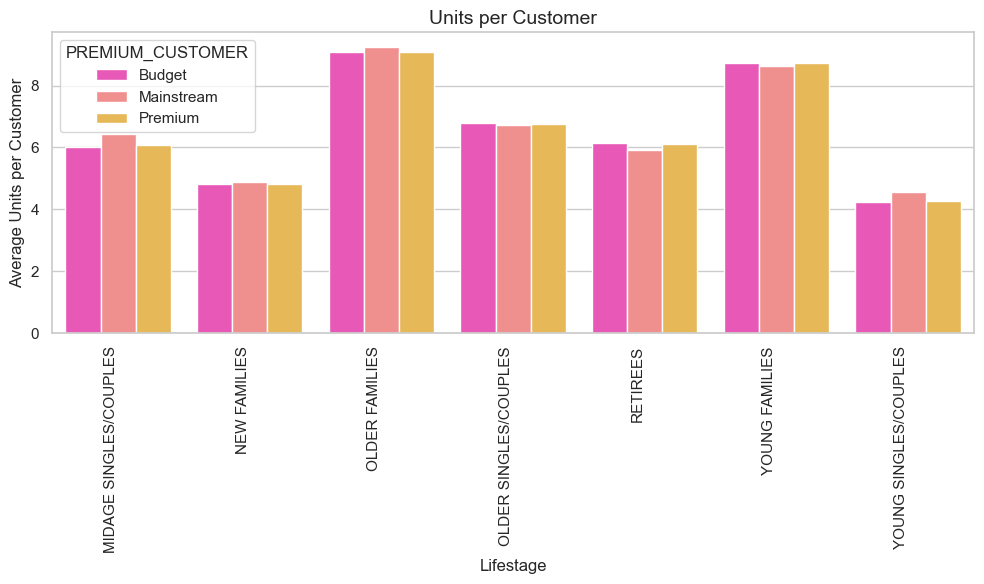

In [27]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(AVG_UNITS=('PROD_QTY', 'sum'), CUSTOMERS=('LYLTY_CARD_NBR', 'nunique')).reset_index()
avg_units['AVG'] = avg_units['AVG_UNITS'] / avg_units['CUSTOMERS']

plt.figure(figsize=(10,6))
sns.barplot(data=avg_units, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER', palette='spring')
plt.title("Units per Customer", fontsize=14)
plt.xlabel("Lifestage")
plt.ylabel("Average Units per Customer")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

Older Families and Young Families generally purchase more chips per customer.

#### Average Price per Unit
Next, we’ll examine the average price per unit of chips for each customer segment, as this also influences total sales.

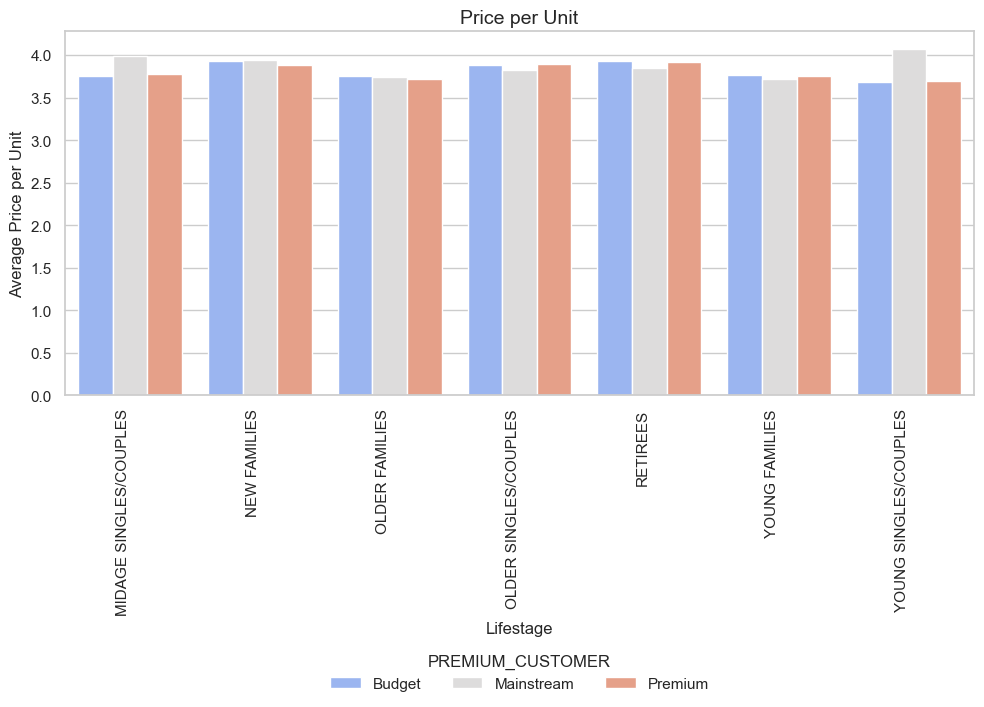

In [28]:
# Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(AVG_PRICE=('TOT_SALES', 'sum'), TOTAL_QTY=('PROD_QTY', 'sum')).reset_index()
avg_price['AVG'] = avg_price['AVG_PRICE'] / avg_price['TOTAL_QTY']

plt.figure(figsize=(10,12))
ax = sns.barplot(data=avg_price, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER', palette='coolwarm')
plt.title("Price per Unit", fontsize=14)
plt.xlabel("Lifestage")
plt.ylabel("Average Price per Unit")
plt.xticks(rotation=90, ha='right')
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.85), ncol=3, frameon=False)
plt.tight_layout()
plt.show()

Mainstream Midage and Young Singles/Couples are willing to pay more per packet of chips compared to their Budget and Premium counterparts. Premium shoppers tend to buy chips mainly for entertainment rather than regular consumption, which is reflected in fewer Premium Midage and Young Singles/Couples purchasing chips.

To determine whether these observed differences are statistically meaningful, we can test if the average price per unit differs between customer segments.

In [29]:
from scipy.stats import ttest_ind

# Perform an independent t‐test between mainstream vs premium and budget midage and young singles and couples
# Subset data & compute price safely
subset = data.loc[data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])].copy()
subset['price'] = subset['TOT_SALES'] / subset['PROD_QTY']

# T-test
ttest_ind(subset.loc[subset['PREMIUM_CUSTOMER']=='Mainstream', 'price'], subset.loc[subset['PREMIUM_CUSTOMER']!='Mainstream', 'price'],
                          equal_var=False, alternative='greater')

TtestResult(statistic=np.float64(37.6243885962295), pvalue=np.float64(3.4836771165090696e-306), df=np.float64(54791.09392740315))

The t-test yields a p-value (0.05) < 3.48e-306, indicating that the unit price for Mainstream Midage and Young Singles/Couples is significantly higher than that of Budget or Premium counterparts.

### Deep Dive into Specific Customer Segments

We identified that Mainstream - Young Singles/Couples are a key segment driving chip sales. Let’s examine their brand preference and pack size affinity compared to the rest of the population.

#### Brand Preference

In [30]:
# Filter target segment
segment = data[(data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream")]
other = data.drop(segment.index)

# Compute brand proportions
seg_prop = segment.groupby('BRAND')['PROD_QTY'].sum() / segment['PROD_QTY'].sum()
other_prop = other.groupby('BRAND')['PROD_QTY'].sum() / other['PROD_QTY'].sum()

# Merge and calculate brand affinity
brand_affinity = pd.DataFrame({'targetSegment': seg_prop, 'other': other_prop})
brand_affinity['affinityToBrand'] = brand_affinity['targetSegment'] / brand_affinity['other']
brand_affinity.sort_values('affinityToBrand', ascending=False)

,targetSegment,other,affinityToBrand
BRAND,,,
TYRRELLS,0.031553,0.025692,1.228095
TWISTIES,0.046184,0.037877,1.219319
DORITOS,0.122761,0.101075,1.214553
KETTLE,0.197985,0.165553,1.195897
TOSTITOS,0.045411,0.037978,1.195713
PRINGLES,0.119420,0.100635,1.186670
COBS,0.044638,0.039049,1.143124
INFUZIONS,0.064679,0.057065,1.133435
THINS,0.060373,0.056986,1.059423


Using the **affinity-to-brand ratio** (target segment proportion ÷ rest of the population proportion), we can identify which brands this segment favors or avoids.

Key insights include:

* **Tyrrells**: Mainstream Young Singles/Couples are about **23% more likely** to purchase Tyrrells chips compared to the rest of the population.
* **Burger Rings**: This segment is approximately **56% less likely** to purchase Burger Rings than others.
* Mainstream Young Singles/Couples show a preference for **DORITOS, KETTLE, and TWISTIES**.

#### Pack Size Preference
Next, we explore whether this segment favors larger pack sizes:

In [31]:
# Preferred pack size compared to the rest of the population
# Calculate the proportion of sales per pack size for the target segment and the rest of the population
seg_pack = segment.groupby('PACK_SIZE')['PROD_QTY'].sum() / segment['PROD_QTY'].sum()
other_pack = other.groupby('PACK_SIZE')['PROD_QTY'].sum() / other['PROD_QTY'].sum()

# Merge and calculate affinity
pack_affinity = pd.DataFrame({'targetSegment': seg_pack, 'other': other_pack})
pack_affinity['affinityToPack'] = pack_affinity['targetSegment'] / pack_affinity['other']
pack_affinity.sort_values('affinityToPack', ascending=False)

,targetSegment,other,affinityToPack
PACK_SIZE,,,
270,0.031829,0.025096,1.268287
380,0.032160,0.025584,1.257030
330,0.061284,0.050162,1.221717
134,0.119420,0.100635,1.186670
110,0.106280,0.089791,1.183637
210,0.029124,0.025121,1.159318
135,0.014769,0.013075,1.129511
250,0.014355,0.012781,1.123166
170,0.080773,0.080986,0.997370


Mainstream Young Singles/Couples are about 27% more likely to purchase a 270g pack of chips compared to the rest of the population. While other pack sizes are purchased, the largest affinity is clearly for the 270g pack, indicating a strong preference for this size within the segment.

#### Linking Pack Size to Brand
Next, let’s explore which **brands** are most commonly purchased in this pack size to gain further insights into their preferences.

In [32]:
data.loc[data['PACK_SIZE'] == 270, ['BRAND', 'PROD_NAME']].drop_duplicates()

,BRAND,PROD_NAME
11,TWISTIES,Twisties Cheese 270g
39,TWISTIES,Twisties Chicken270g


It turns out that **Twisties** is the only brand offering 270g packs. Therefore, the higher likelihood of purchasing a 270g pack among Mainstream Young Singles/Couples may actually reflect a stronger preference for **Twisties** rather than the pack size itself.

## Conclusion

Our analysis reveals clear patterns in chip purchases across different customer segments:  

1. **Top Sales Segments:** Budget - Older Families, Mainstream - Young Singles/Couples, and Mainstream - Retirees drive the majority of chip sales, mainly due to higher customer numbers and, for some segments, greater purchase volume per customer.  

2. **Buying Behavior:** Mainstream Midage and Young Singles/Couples tend to pay more per packet, reflecting impulse buying tendencies rather than routine purchases.  

3. **Brand & Pack Preferences:**  
   - Tyrrells is particularly favored by Mainstream Young Singles/Couples, who are **~23% more likely** to buy it than the general population.  
   - The 270g pack shows the highest affinity for this segment (**~27% more likely**), largely due to Twisties offering this size.  

4. **Implications for Strategy:** Placing popular brands and preferred pack sizes in high-traffic areas frequented by Young Singles/Couples, coupled with targeted promotions during holidays, could boost impulse purchases and overall sales.  

**Overall Insight:** By aligning product placement and promotions with segment-specific preferences, category managers can **maximize sales, improve customer engagement, and better meet the needs of high-value segments**.